## **Step 0: Imports and Reading Data**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


plt.style.use('ggplot')
pd.set_option('display.max_columns', 20)


In [44]:
df = pd.read_csv('Food_Inspections.csv')

## **Step 1: Data understating**

In [41]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Results,Latitude,Longitude,Location
4,2587088,URBAN LUXE CAFE INC.,URBAN LUXE CAFE INC.,2917499.0,Restaurant,Risk 2 (Medium),2911 E 79TH ST,CHICAGO,IL,60649.0,NaN,License,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,Pass,41.751791,-87.553571,"(41.751791151661955, -87.55357107463779)"
7,2587105,MADINA GROCERS INC.,MADINA GROCERS INC.,2943538.0,Grocery Store,Risk 2 (Medium),2507 W DEVON AVE,CHICAGO,IL,60659.0,NaN,License,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,Pass,41.997572,-87.692633,"(41.99757189442386, -87.69263305087995)"
9,2587101,BLAZED BAKERY CHICAGO,BLAZED BAKERY CHICAGO,2912294.0,Restaurant,Risk 2 (Medium),2415 N MILWAUKEE AVE,CHICAGO,IL,60647.0,NaN,License,27. FOOD ADDITIVES: APPROVED AND PROPERLY USED...,Fail,41.925162,-87.700799,"(41.92516159485552, -87.70079914992428)"
10,2587010,BITTERSWEET,BITTERSWEET,2923803.0,Restaurant,Risk 1 (High),2019 S LAFLIN ST,CHICAGOO,IL,60608.0,NaN,License Re-Inspection,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,Pass,41.854493,-87.663530,"(41.854493434030644, -87.66352975090798)"
13,2587016,J & J FISH AND CHICKEN,J & J FISH AND CHICKEN,2841429.0,Restaurant,Risk 2 (Medium),1600 W MARQUETTE RD,CHICAGO,IL,60636.0,NaN,License,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,Fail,41.772301,-87.664086,"(41.77230075905835, -87.66408586993496)"


In [45]:
df.shape

(264889, 17)

In [46]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Results', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [47]:
df.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Results             object
Latitude           float64
Longitude          float64
Location            object
dtype: object

In [48]:
df.describe()

,Inspection ID,License #,Zip,Latitude,Longitude
count,2.648890e+05,2.648720e+05,264807.000000,263981.000000,263981.000000
mean,1.721156e+06,1.717980e+06,60628.709324,41.880791,-87.676527
std,7.178647e+05,9.254883e+05,149.614543,0.081096,0.058651
min,4.424700e+04,0.000000e+00,10014.000000,41.644670,-87.914428
25%,1.301095e+06,1.335879e+06,60614.000000,41.831831,-87.707703
50%,1.948505e+06,2.046682e+06,60625.000000,41.891797,-87.666559
75%,2.352951e+06,2.368426e+06,60643.000000,41.939808,-87.634955
max,2.587117e+06,9.999999e+06,90504.000000,42.021064,-87.525094


In [49]:
for column in df.columns:
    print(f'Unique values in {column}: {df[column].nunique()}')

Unique values in Inspection ID: 264889
Unique values in DBA Name: 32014
Unique values in AKA Name: 30475
Unique values in License #: 44280
Unique values in Facility Type: 511
Unique values in Risk: 4
Unique values in Address: 19589
Unique values in City: 78
Unique values in State: 5
Unique values in Zip: 121
Unique values in Inspection Date: 3527
Unique values in Inspection Type: 110
Unique values in Violations: 191074
Unique values in Results: 7
Unique values in Latitude: 18168
Unique values in Longitude: 18168
Unique values in Location: 18168


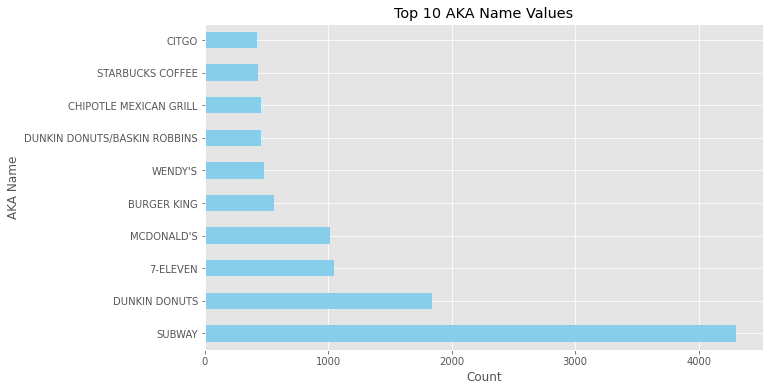

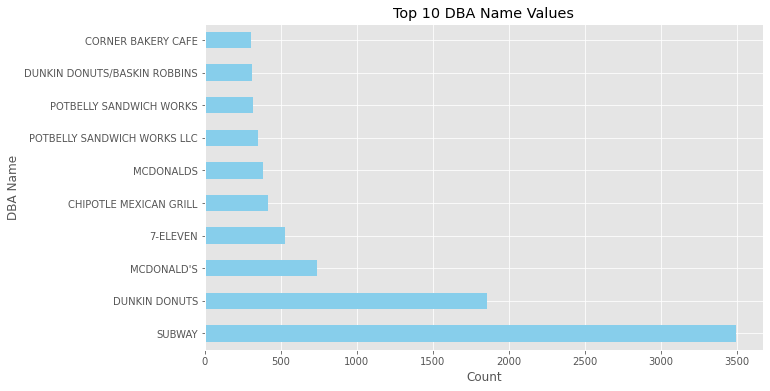

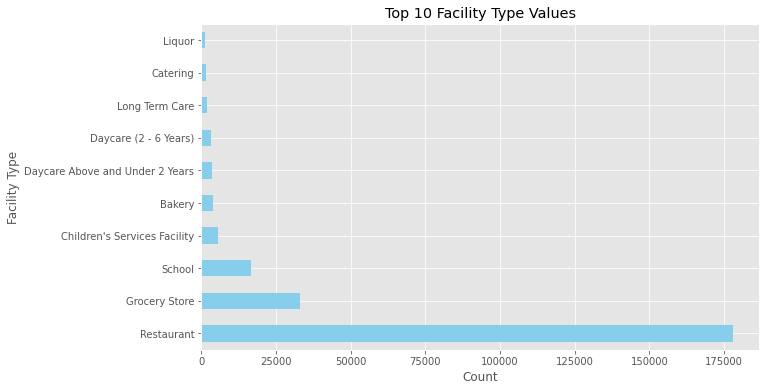

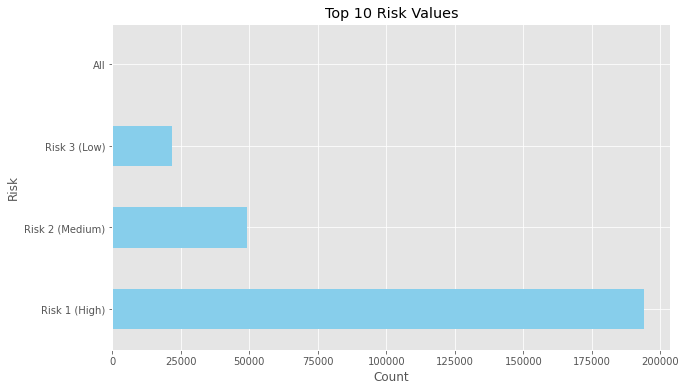

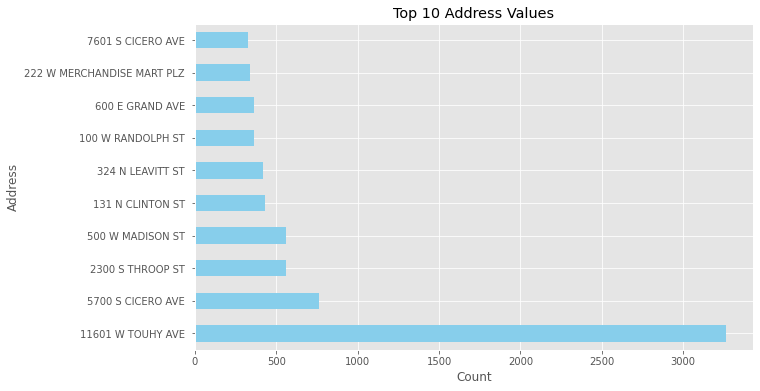

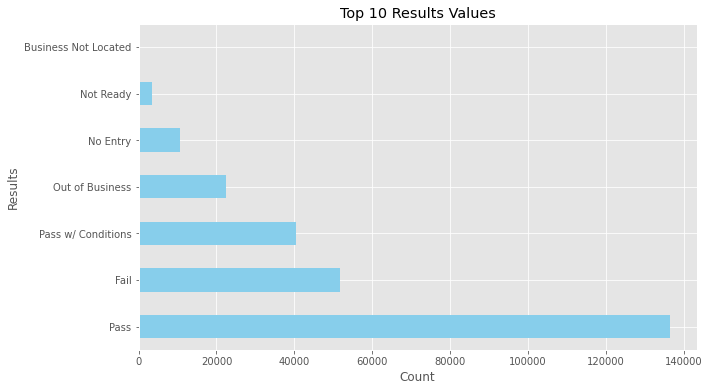

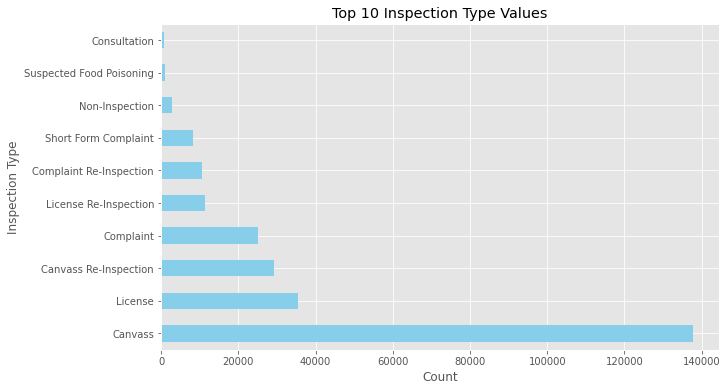

In [50]:
columns_to_plot = ['AKA Name','DBA Name','Facility Type','Risk', 'Address','Results', 'Inspection Type']

for column in columns_to_plot:
    column_counts = df[column].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    column_counts.plot(kind='barh', color='skyblue')
    plt.title(f'Top 10 {column} Values')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()



## **Step 2: Data Cleaning**

**Remove rows that are not in Chicago**

In [51]:
df = df[df['City'].str.contains('chicago', case=False, na=False)]

**Remowe rows that are not Pass,Fail or Pass w/Conditions and replace Pass w/Conditions in Pass**

In [52]:
values_to_remove = ['No Entry', 'Not Ready', 'Out of Business', 'Business Not Located']
df = df[~df['Results'].isin(values_to_remove)]
df['Results'] = df['Results'].replace('Pass w/ Conditions', 'Pass')

**Remowe rows where is no logic and that rows where risk is All or Nan**

In [53]:
df = df[~((df['Results'] == 'Pass') & (df['Violations'].isna()) & (df['Risk'] == 'Risk 1 (High)'))]
df = df[~((df['Results'] == 'Fail') & (df['Violations'].isna()) & (df['Risk'] == 'Risk 3 (Low)'))]
# df['Results'] = df['Results'].replace('Pass', 1.0) #1 ancela stugum
# df['Results'] = df['Results'].replace('Fail', 0.0) #0 chi ancel stugum
df = df[~df['Risk'].isin(['All']) & ~df['Risk'].isna()]
# risk_mapping = {'Risk 1 (High)': 1, 'Risk 2 (Medium)': 0.5, 'Risk 3 (Low)': 0}
# df['Risk'] = df['Risk'].replace(risk_mapping)

**Drop rows whitout latitude or longitude or location and rows with 0 as licence number**

In [54]:
df.dropna(subset = ["Latitude", "Longitude","Location"], inplace=True)
df.drop(df[df['License #'] == 0].index, inplace=True)

**Only keep the year of the inspection**

In [55]:
df["Inspection Date"] = df["Inspection Date"].str.split("/").str[2]

**Focus on the facility types: Restaurant, Grocery Store, School**

In [56]:
df.groupby('Facility Type')['Facility Type'].count().sort_values(ascending=False).head(20)

Facility Type
Restaurant                         138269
Grocery Store                       27233
School                              14110
Children's Services Facility         4072
Bakery                               3158
Daycare Above and Under 2 Years      2684
Daycare (2 - 6 Years)                2169
Long Term Care                       1632
Catering                             1110
Liquor                                914
Mobile Food Preparer                  759
Mobile Food Dispenser                 715
Golden Diner                          551
Hospital                              547
Daycare Combo 1586                    483
Wholesale                             478
TAVERN                                312
Daycare (Under 2 Years)               209
GAS STATION                           169
Shared Kitchen User (Long Term)       156
Name: Facility Type, dtype: int64

In [57]:
df = df[df["Facility Type"].isin(["Restaurant","Grocery Store", "School"])]
df["Facility Type"].value_counts()

Facility Type
Restaurant       138269
Grocery Store     27233
School            14110
Name: count, dtype: int64

**Drop useless columns**

In [58]:
columns_to_drop = ['Inspection ID','AKA Name','City','Zip','Latitude','Longitude','License #','State']
df = df.drop(columns=columns_to_drop)

In [59]:
df.head()

,DBA Name,Facility Type,Risk,Address,Inspection Date,Inspection Type,Violations,Results,Location
4,URBAN LUXE CAFE INC.,Restaurant,Risk 2 (Medium),2911 E 79TH ST,2023,License,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,Pass,"(41.751791151661955, -87.55357107463779)"
7,MADINA GROCERS INC.,Grocery Store,Risk 2 (Medium),2507 W DEVON AVE,2023,License,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,Pass,"(41.99757189442386, -87.69263305087995)"
9,BLAZED BAKERY CHICAGO,Restaurant,Risk 2 (Medium),2415 N MILWAUKEE AVE,2023,License,27. FOOD ADDITIVES: APPROVED AND PROPERLY USED...,Fail,"(41.92516159485552, -87.70079914992428)"
10,BITTERSWEET,Restaurant,Risk 1 (High),2019 S LAFLIN ST,2023,License Re-Inspection,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,Pass,"(41.854493434030644, -87.66352975090798)"
13,J & J FISH AND CHICKEN,Restaurant,Risk 2 (Medium),1600 W MARQUETTE RD,2023,License,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,Fail,"(41.77230075905835, -87.66408586993496)"


**Drop duplicated rows**

In [60]:
df.duplicated().sum()#Nayum enq dublikatneri qanak

1063

In [61]:
df = df.drop_duplicates()#jnjumenq duplicatnery|

In [63]:
df.isna().sum()#Vor syunakum qani 0 ka kam chlracvac ban

## **Step 3: Feature Understanding**

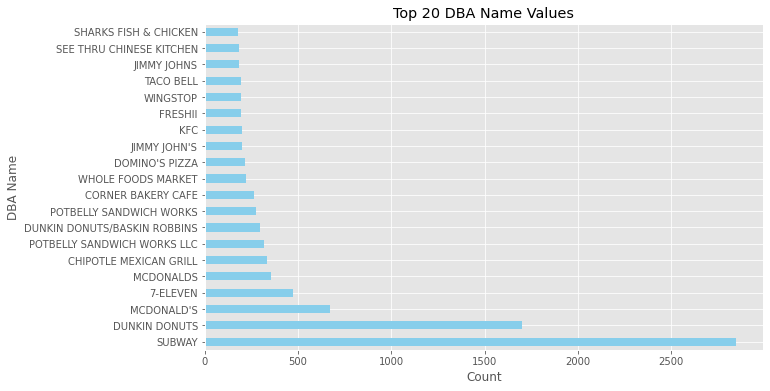

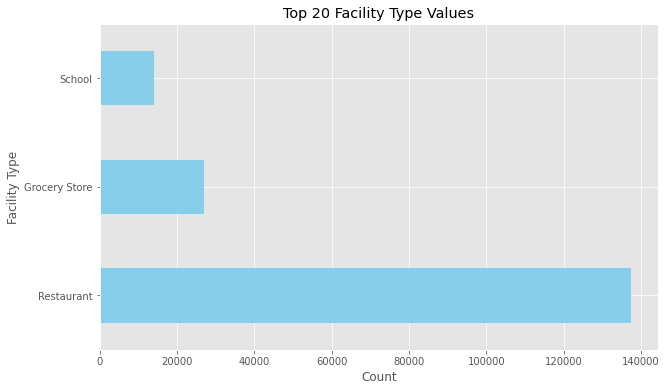

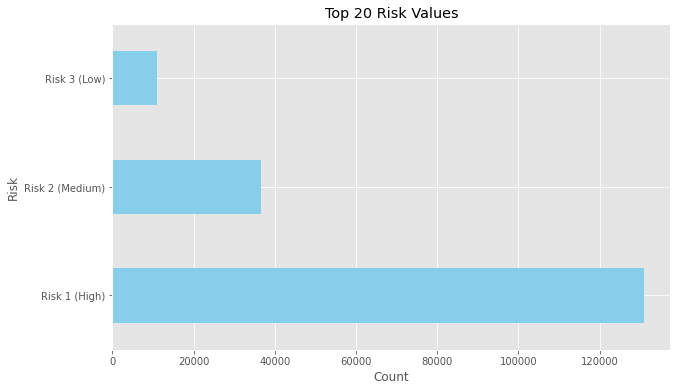

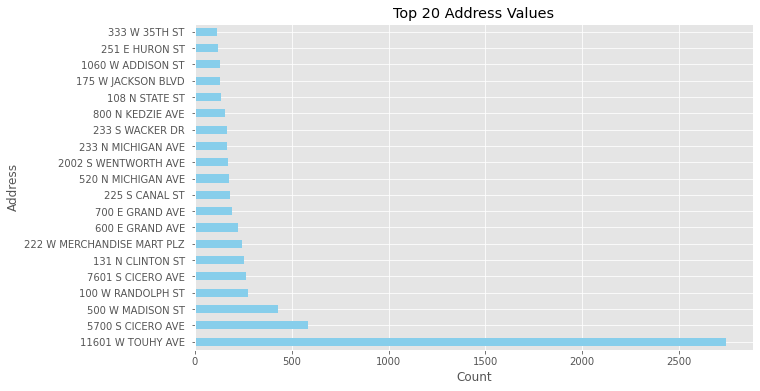

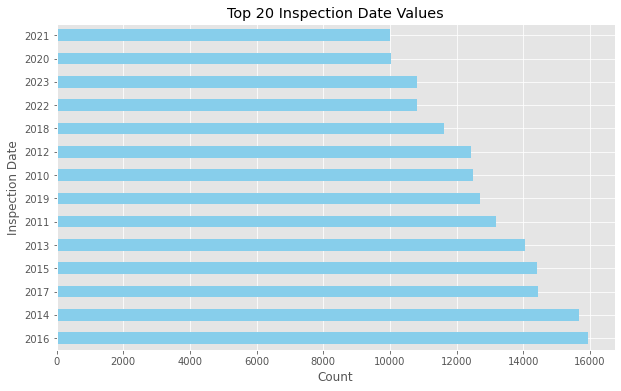

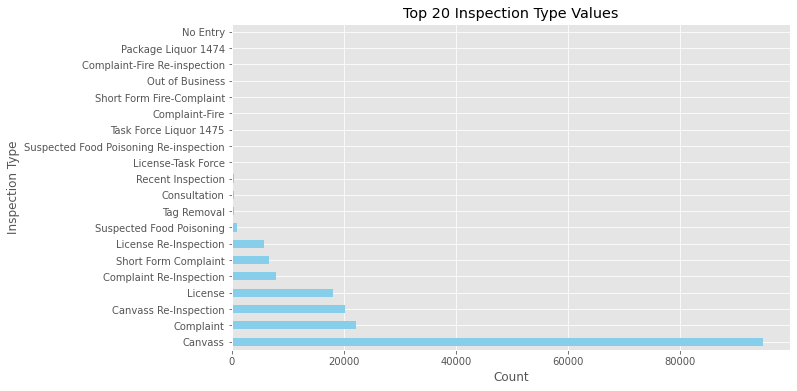

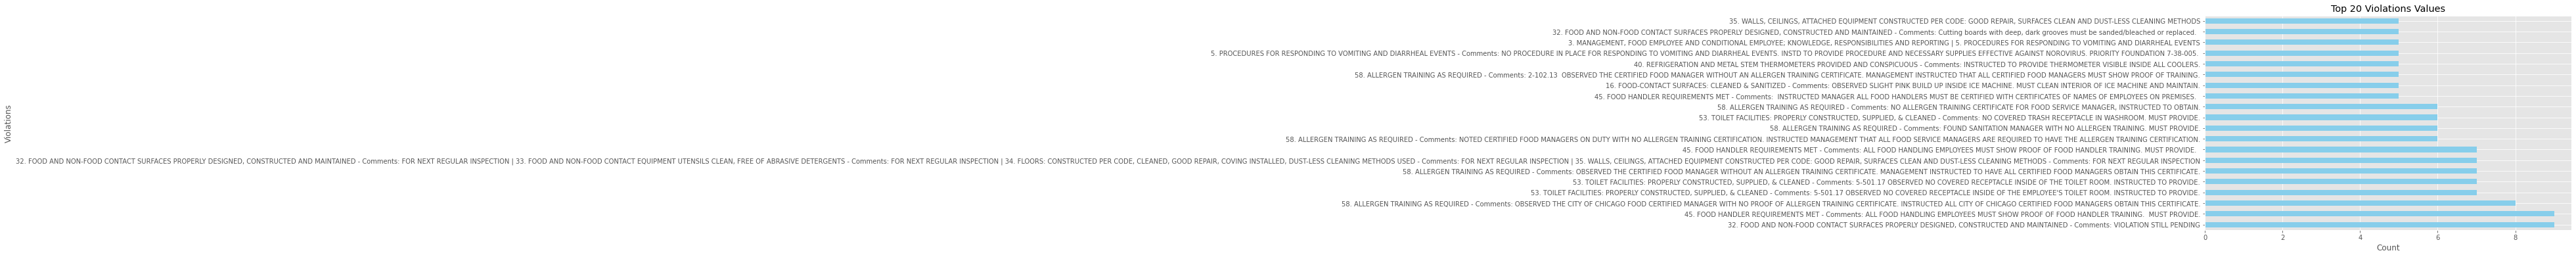

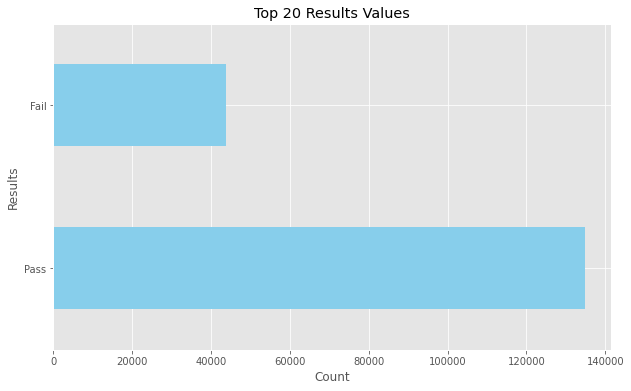

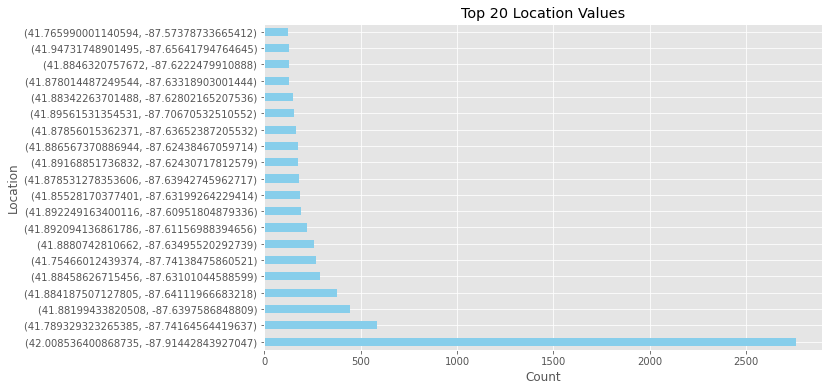

In [65]:
for column in df.columns:
    column_counts = df[column].value_counts().head(20)
    plt.figure(figsize=(10, 6))
    column_counts.plot(kind='barh', color='skyblue')
    plt.title(f'Top 20 {column} Values')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()

## **Step 4: Feature Realationships**

Decision Tree Accuracy: 0.8648931205077943
Random Forest Accuracy: 0.8643890600205358
Logistic Regression Accuracy: 0.7621581256417437


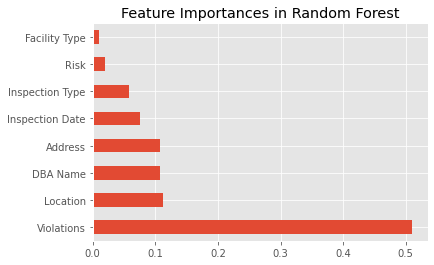

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])
X = df.drop('Results', axis=1)
y = df['Results']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Настройка гиперпараметров для Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_tree_params = grid_search.best_params_
best_tree_model = grid_search.best_estimator_

# Использование RandomForest с наилучшими параметрами
best_forest_model = RandomForestClassifier(random_state=42)
best_forest_model.fit(X_train, y_train)

# Использование Logistic Regression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Вывод результатов
models = {
    'Decision Tree': best_tree_model,
    'Random Forest': best_forest_model,
    'Logistic Regression': logistic_model
}

for model_name, model in models.items():
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{model_name} Accuracy: {accuracy}")

# Визуализация важности признаков для RandomForest
feature_importances = pd.Series(best_forest_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances in Random Forest')
plt.show()